## **INTRODUÇÃO**

Nessa atividade, serão desenvolvidas duas abordagens de implementação de Redes Neurais Recorrentes (RNN). Essas redes funcionam de forma que a rede em si processa um item de entrada de cada vez e o item que vem em sequência é sempre influenciado pela entrada anterior. Enquanto as redes neurais tradicionais (como as feedforward) tratam cada entrada do modelo de forma isolada, as RNNs são projetadas para lembrar o que foi processado anteriormente, possuindo uma memória interna. Essa memória é atualizada a cada passo da sequência, permitindo que a rede capture padrões temporais e contextuais.

A diferença de funcionamento das redes recorrentes para as redes "*feed-forward*" pode ser vista de forma mais lúdica na imagem abaixo:


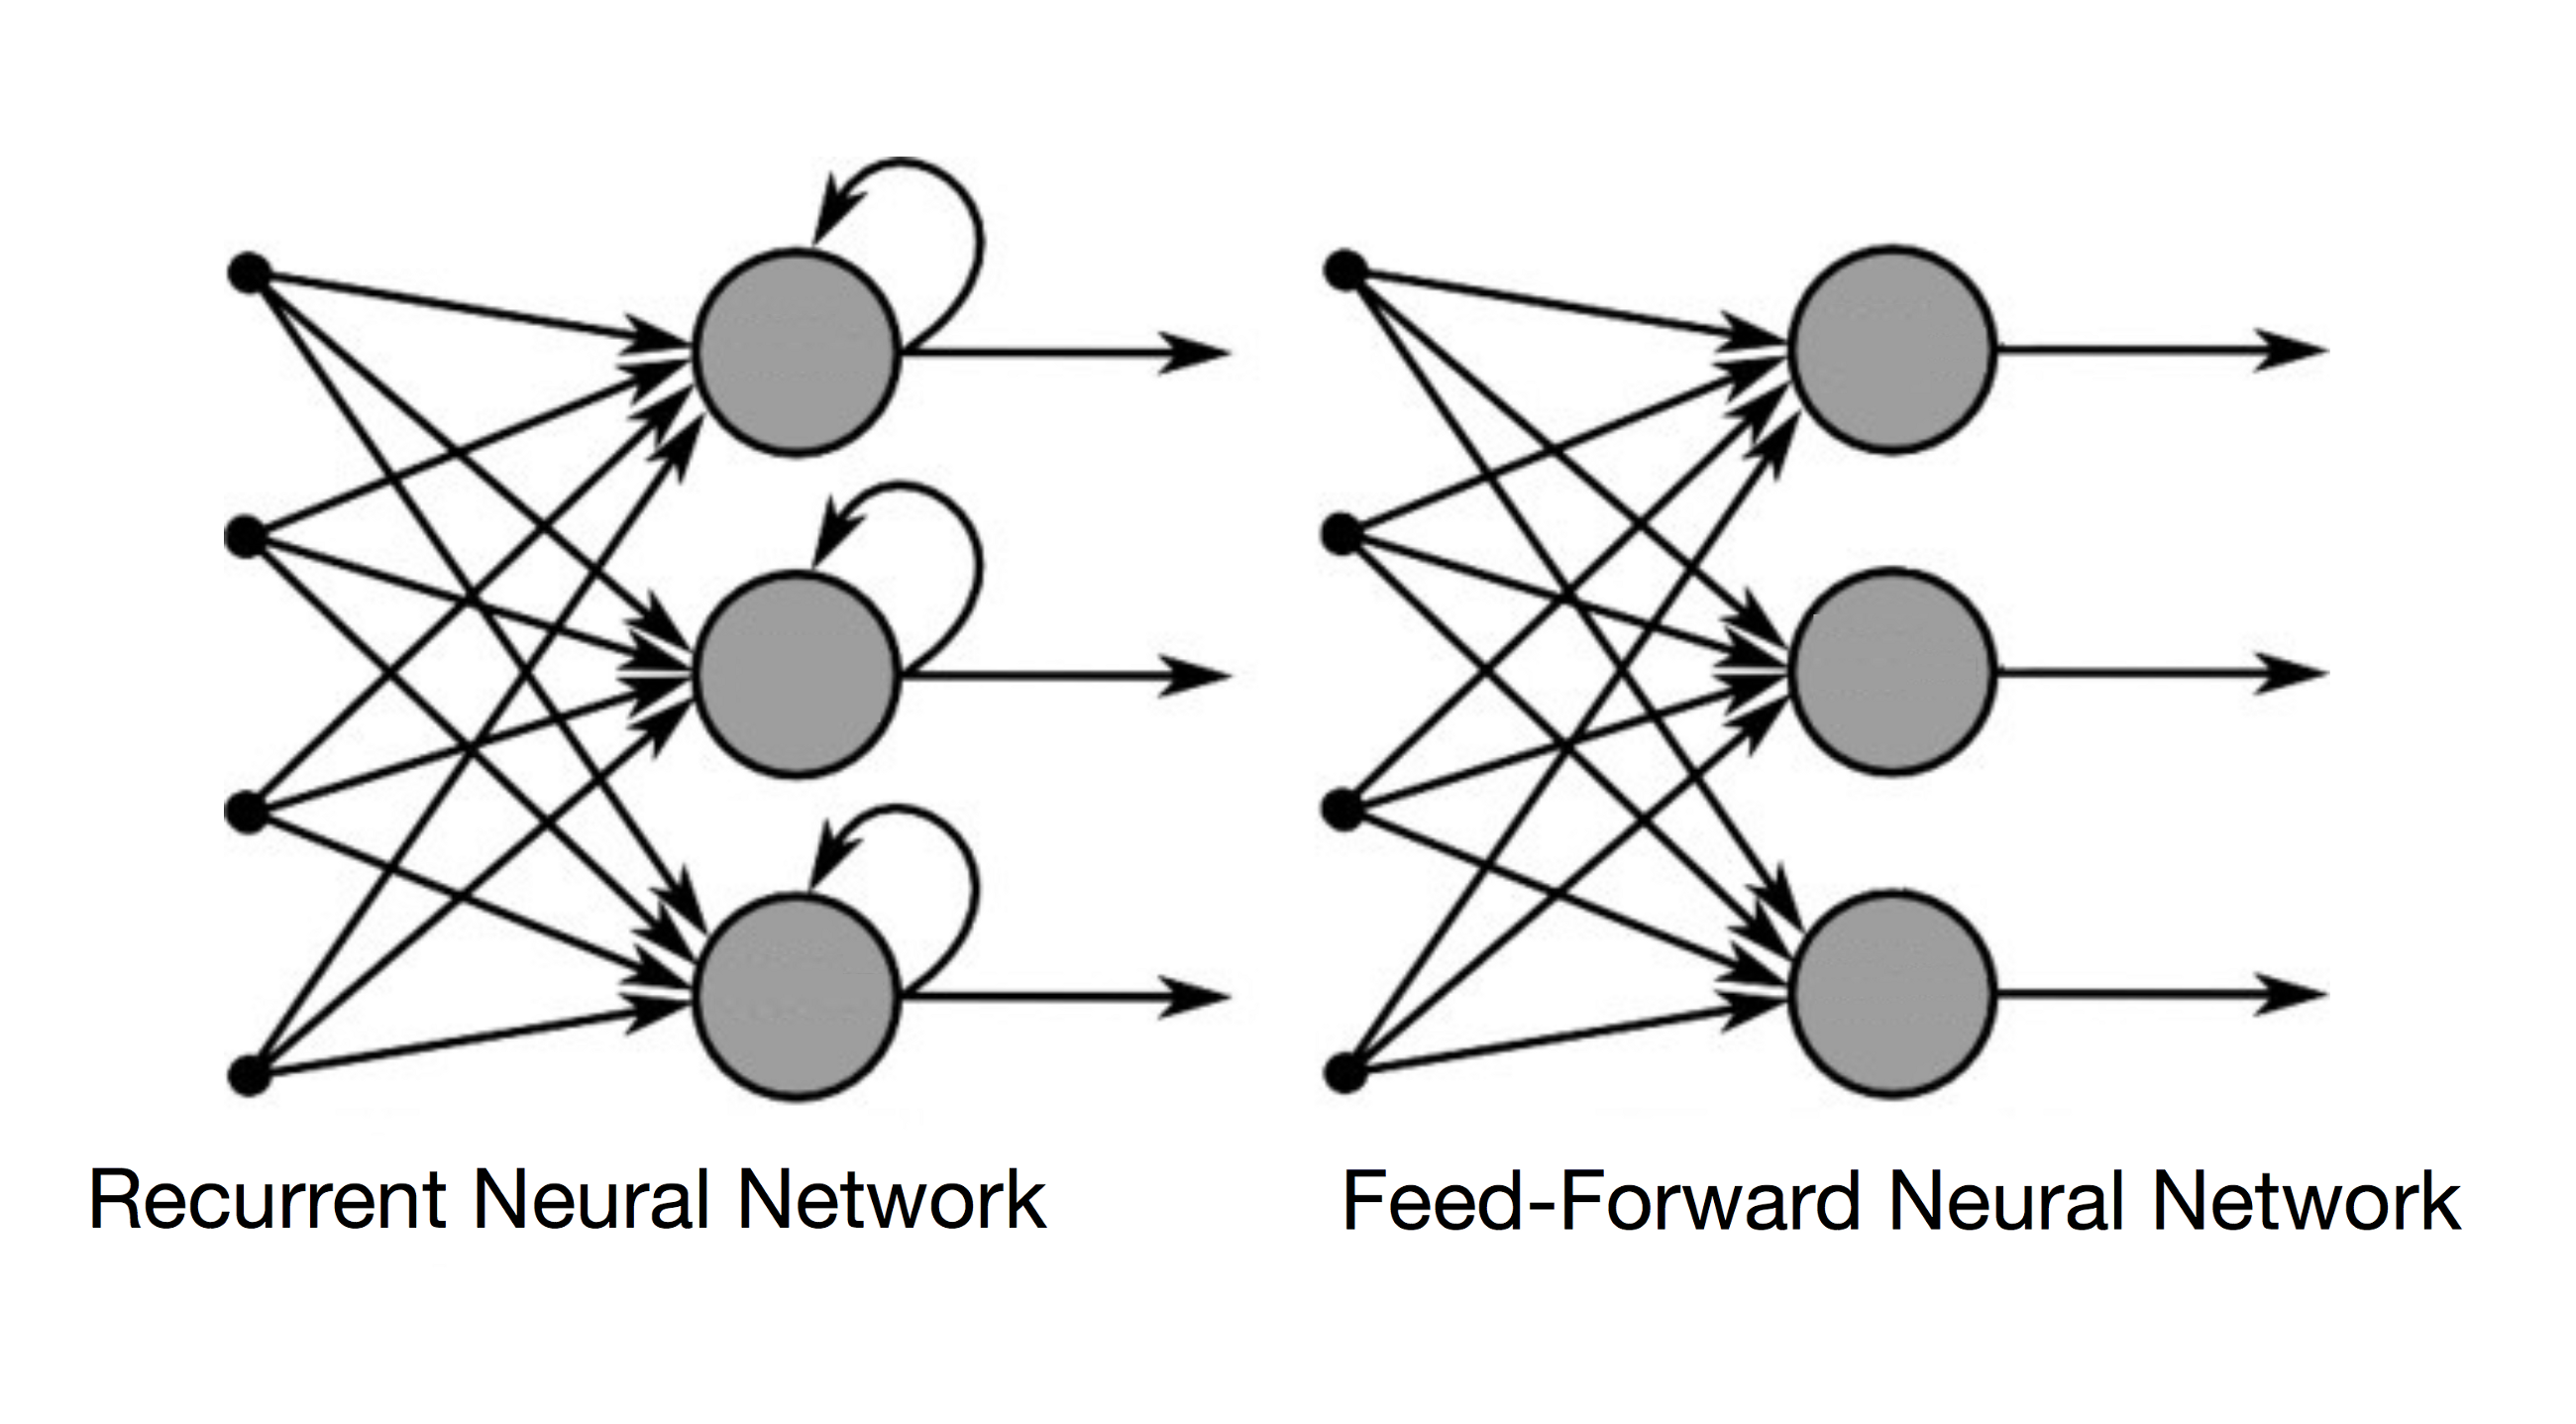

###### Fonte: Deep Learning Book

Maravilha! Agora que sabemos um pouco mais sobre o que exatamente são as redes neurais recorrentes, vamos fazer duas abordagens para implementação desses modelos nos nossos dados (que precisam ser sequenciais). Vamos lá?

---

## **CÓDIGOS**

Primeiro, como feito sempre, vamos importar as bibliotecas que iremos utilizar no desenvolvimento do nosso notebook:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

No caso da atividade a ser desenvolvida nesse notebook, como falado anteriormente, serão realizadas duas abordagens diferentes para utilização do RNN.

A primeira delas, que começaremos agora, será utilizando dados sequencias de clima, importados a partir do site Kaggle [4] e que mostram dados obtidos de consumo de energia nos EUA.

Vamos pensar nela e jaja falaremos da outra abordagem:

### ***ABORDAGEM I: DADOS SEQUENCIAIS DE CLIMA***

Nesse primeiro caso, vamos definir uma classe de redes neurais recorrentes de regressão, dado que vamos utilizar dados sequenciais numéricos.

O modelo funciona de modo a utilizar uma única camada RNN e com uma sequência de recebimento do último valor obtido dessa RNN para utilização em uma "nova" rede totalmente conectada com a função de ativação ReLU.

In [2]:
class RNNRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=1):
        super(RNNRegressor, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 100)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]  # última saída da sequência
        return self.fc(out)

modelo_1 = RNNRegressor()
print(modelo_1)

RNNRegressor(
  (rnn): RNN(1, 100, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


Agora podemos baixar os dados do em DataFrame, transformar tudo em datas e horas e ordená-los:

In [3]:
df = pd.read_csv('AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values(by='Datetime')
df

,Datetime,AEP_MW
2183,2004-10-01 01:00:00,12379.0
2184,2004-10-01 02:00:00,11935.0
2185,2004-10-01 03:00:00,11692.0
2186,2004-10-01 04:00:00,11597.0
2187,2004-10-01 05:00:00,11681.0
...,...,...
116157,2018-08-02 20:00:00,17673.0
116158,2018-08-02 21:00:00,17303.0
116159,2018-08-02 22:00:00,17001.0
116160,2018-08-02 23:00:00,15964.0


Obtemos os dados calculados como e os normalizamos com o "MinMaxScaler":

In [4]:
scaler = MinMaxScaler()
valores = scaler.fit_transform(df['AEP_MW'].values.reshape(-1, 1)).flatten()

valores

array([0.17363783, 0.14608415, 0.1310041 , ..., 0.46046916, 0.39611518,
       0.32443838])

Aqui, iremos criar uma função que criará janelas deslizantes de 1 dia (24 horas) como X para prevermos o valor seguinte de y:

In [5]:
def criar_sequencias(data, comprimento_sequencia):
    xs = []
    ys = []
    for i in range(len(data) - comprimento_sequencia):
        x = data[i:(i + comprimento_sequencia)]
        y = data[i + comprimento_sequencia]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [6]:
comprimento_sequencia = 24
X, y = criar_sequencias(valores, comprimento_sequencia)

In [7]:
X, y

(array([[0.17363783, 0.14608415, 0.1310041 , ..., 0.326176  , 0.27839146,
         0.22129825],
        [0.14608415, 0.1310041 , 0.1251086 , ..., 0.27839146, 0.22129825,
         0.16625295],
        [0.1310041 , 0.1251086 , 0.13032146, ..., 0.22129825, 0.16625295,
         0.12976294],
        ...,
        [0.41057466, 0.3523644 , 0.28199082, ..., 0.52978776, 0.50217202,
         0.47921062],
        [0.3523644 , 0.28199082, 0.22992429, ..., 0.50217202, 0.47921062,
         0.46046916],
        [0.28199082, 0.22992429, 0.18654586, ..., 0.47921062, 0.46046916,
         0.39611518]]),
 array([0.16625295, 0.12976294, 0.10990443, ..., 0.46046916, 0.39611518,
        0.32443838]))

A partir disso, dividimos tais dados em treino e teste, além de realizar a transformação para tensores no intuito de funcionar com a biblioteca Pytorch:

In [8]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=False)

X_treino_tensor = torch.tensor(X_treino, dtype=torch.float).unsqueeze(-1)
X_teste_tensor = torch.tensor(X_teste, dtype=torch.float).unsqueeze(-1)
y_treino_tensor = torch.tensor(y_treino, dtype=torch.float)
y_teste_tensor = torch.tensor(y_teste, dtype=torch.float)

Com isso, iremos criar uma classe que, basicamente, criará datasets baseado no tamanho do batch para utilização no nosso treinamento. A partir desses datasets, nós faremos nossos loaders:

In [9]:
class SerieTemporalDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
batch_size = 32

data_treino = SerieTemporalDataset(X_treino_tensor, y_treino_tensor)
data_teste = SerieTemporalDataset(X_teste_tensor, y_teste_tensor)

In [11]:
train_loader = DataLoader(data_treino, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_teste, batch_size=batch_size, shuffle=False)

Com tudo já definido, instanciamos o modelo e definimos as características do nosso treinamento:

In [12]:
modelo_1 = RNNRegressor()
funcao_de_perda = nn.MSELoss()
TAXA_DE_APRENDIZADO = 1e-3
EPOCAS = 20

Para melhorar o desempenho, também utilizaremos o otimizador Adam

###### \* O funcionamento na teoria do otimizador em si pode ser visto de forma mais detalhado nas referências [6] e [7] desse notebook

In [13]:
otimizador = optim.Adam(modelo_1.parameters(), lr=TAXA_DE_APRENDIZADO)

Agora, com tudo já definido e pronto, podemos fazer o nosso treinamento por épocas

In [14]:
lista_perdas = []

for epoca in range(EPOCAS):
    modelo_1.train()
    perda = 0

    for X_batch, y_batch in train_loader:
        outputs = modelo_1(X_batch)

        # --------
        # Cálculo da perda baseada na função de perda
        # --------
        loss = funcao_de_perda(outputs, y_batch)

        # --------
        # Realização do Backpropagation e otimização com o Adam
        # --------
        otimizador.zero_grad()
        loss.backward()
        otimizador.step()

        perda += loss.item()

    perda_media = perda / len(train_loader)
    lista_perdas.append(perda_media)
    print(f"Época [{epoca+1}/{EPOCAS}], Perda média: {perda_media:.6f}")

C:\Users\caio24034\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


C:\Users\caio24034\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Época [1/20], Perda média: 0.026647
Época [2/20], Perda média: 0.025968
Época [3/20], Perda média: 0.025924
Época [4/20], Perda média: 0.025903
Época [5/20], Perda média: 0.025893
Época [6/20], Perda média: 0.025879
Época [7/20], Perda média: 0.025891
Época [8/20], Perda média: 0.025892
Época [9/20], Perda média: 0.025873
Época [10/20], Perda média: 0.025863
Época [11/20], Perda média: 0.025870
Época [12/20], Perda média: 0.025885
Época [13/20], Perda média: 0.025866
Época [14/20], Perda média: 0.025870
Época [15/20], Perda média: 0.025870
Época [16/20], Perda média: 0.025862
Época [17/20], Perda média: 0.025866
Época [18/20], Perda média: 0.025864
Época [19/20], Perda média: 0.025852
Época [20/20], Perda média: 0.025868


E com as perdas por época agora ja obtidas, vamos buscar um entendimento mais visual do treinamento do nosso modelo por meio da curva de aprendizado, que pode ser vista abaixo:

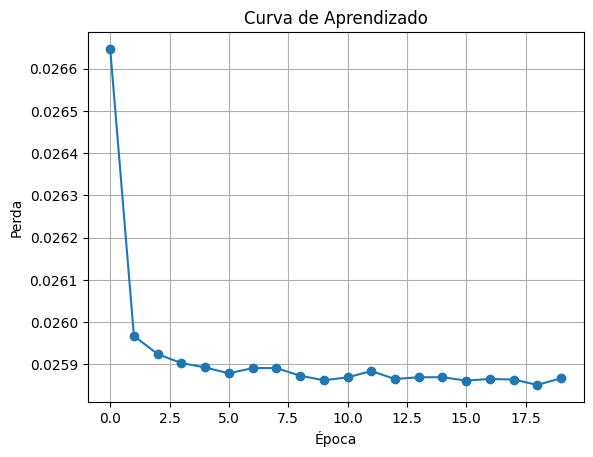

In [15]:
plt.plot(lista_perdas, marker='o')
plt.xlabel("Época")
plt.ylabel("Perda")
plt.title("Curva de Aprendizado")
plt.grid(True)
plt.show()

Com o treinamento pelas épocas já realizado, podemos ver um aprendizado bem marcante do modelo, de forma que, mesmo com uma certa instabilidade, o valor tende a um mínimo.

---

### ***ABORDAGEM II: TRATAR IMAGENS COMO DADOS SEQUENCIAIS***

Já nesse segundo caso, faremos algo um tanto diferente. Pensaremos em imagens como dados sequenciais, dado que a localização e ordem de cada pixel numa imagem importa (e muito!) para a composição daquela imagem.

Assim, vamos desenvolver uma classe para RNN que segue o mesmo princípio da primeira abordagem, mas é implementada de forma bem similar àquela que vimos na Fera Formidável 4.6.

Basicamente, a rede funcionando conectando uma RNN com uma rede totalmente conectada para treinamento em épocas, só que, nesse caso, com foco em imagens e suas propriedades.

In [16]:
class RNN(nn.Module):
    def __init__(self, tamanho_input = 28, tamanho_hidden = 100, n_camadas = 1, n_classes = 10):
        super(RNN, self).__init__()
        self.tamanho_hidden = tamanho_hidden
        self.n_camadas = n_camadas
        self.rnn = nn.RNN(tamanho_input, tamanho_hidden, n_camadas, batch_first=True, nonlinearity='relu')
        self.fc1 = nn.Sequential(nn.Linear(tamanho_hidden, 64), nn.ReLU())
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        h0 = torch.zeros(self.n_camadas, x.size(0), self.tamanho_hidden)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.fc2(out)
        return out

modelo_2 = RNN()

print(modelo_2)

RNN(
  (rnn): RNN(28, 100, batch_first=True)
  (fc1): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


Baixaremos os dados, vamos dividi-los e transformá-los.

In [17]:
# Pequena transformação para tensores e normalizando o tamanho
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Train/Test Datasets
data_treino_2 = datasets.MNIST(root='./data', train=True, transform=trans, download=True)
data_teste_2 = datasets.MNIST(root='./data', train=False, transform=trans, download=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.40MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 214kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 254kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.54MB/s]


In [18]:
data_treino_2, data_teste_2

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

Nessa etapa vamos dividir nossos dados em lotes para que seja mais fácil convergir os pesos. Observe também que, nesse passo, usamos o *shuffle = True* para embaralhar os dados, fazendo que o modelo não seja influenciado pela ordem dos dados.

In [19]:
batch_size = 32 #tamanho do lote

train_loader = DataLoader(data_treino_2, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_teste_2, batch_size=batch_size, shuffle=False)

Pelo números de parâmetros obtidos ser um tanto quanto alto, nós podemos utilizar a GPU disponibilizada pelo próprio Google Colab:

In [27]:
def count_parameters(modelo):
    return sum(p.numel() for p in modelo.parameters() if p.requires_grad)

count_parameters(modelo_2)

20114

In [28]:
#torch.cuda.is_available()

In [29]:
#torch.cuda.get_device_name()

Instanciamos o novo modelo e damos as informações necessárias pro treinamento acontecer:

In [30]:
modelo_2 = RNN()
funcao_de_perda = nn.CrossEntropyLoss()
TAXA_DE_APRENDIZADO = 1e-3
EPOCAS = 20

E, de novo, otimizamos pelo otimizador Adam:

In [31]:
otimizador = optim.Adam(modelo_2.parameters(), lr=TAXA_DE_APRENDIZADO)

E agora, vamos de treinamento computando a perda e acurácia para analisarmos graficamente depois:

In [32]:
lista_perdas = []
lista_acuracias = []

# Loop de treino
for epoca in range(EPOCAS):
    modelo_2.train()
    perda = 0
    lista_acuracia = []

    for (images, labels) in train_loader: ### para cada batch

        images = images.squeeze(1)  ### nesse passo, vamos, basicamente, redimensionar a imagem para que ela saia de um formato (B, 1, 28, 28) para (B, 28, 28)

        outputs = modelo_2(images)

        # --------
        # Cálculo da perda baseada na função de perda
        # --------
        loss = funcao_de_perda(outputs, labels)

        # --------
        # Realização do Backpropagation e otimização com o Adam
        # --------
        otimizador.zero_grad()
        loss.backward()
        otimizador.step()

        perda += loss.item()

        # --------
        # Para cálculo da acurácia
        # --------
        total = labels.size(0)
        _, preditos = torch.max(outputs.data, 1) # pega o valor mais alto das probabilidades das 10 classes possíveis.
        correto = (preditos == labels).sum().item() # somar o número de acertos
        lista_acuracia.append(correto / total)

    perda_media = perda / len(train_loader) # soma das perdas de todos os batches da época/ número de batches
    acuracia_media = sum(lista_acuracia) / len(lista_acuracia)# soma todas as acurácias dos batches/número de batches

    lista_perdas.append(perda_media)
    lista_acuracias.append(acuracia_media)

    print(f"Época [{epoca+1}/{EPOCAS}], Perda média: {perda_media:.4f}, Acurácia média: {acuracia_media:.4f}")

Época [1/20], Perda média: 0.6145, Acurácia média: 0.7892
Época [2/20], Perda média: 0.2352, Acurácia média: 0.9312
Época [3/20], Perda média: 0.1845, Acurácia média: 0.9459
Época [4/20], Perda média: 0.1631, Acurácia média: 0.9522
Época [5/20], Perda média: 0.1467, Acurácia média: 0.9572
Época [6/20], Perda média: 0.1358, Acurácia média: 0.9616
Época [7/20], Perda média: 0.1269, Acurácia média: 0.9639
Época [8/20], Perda média: 0.1174, Acurácia média: 0.9665
Época [9/20], Perda média: 0.1218, Acurácia média: 0.9651
Época [10/20], Perda média: 0.1085, Acurácia média: 0.9693
Época [11/20], Perda média: 0.1058, Acurácia média: 0.9694
Época [12/20], Perda média: 0.0981, Acurácia média: 0.9721
Época [13/20], Perda média: 0.0943, Acurácia média: 0.9729
Época [14/20], Perda média: 0.1027, Acurácia média: 0.9710
Época [15/20], Perda média: 0.0945, Acurácia média: 0.9735
Época [16/20], Perda média: 0.0989, Acurácia média: 0.9726
Época [17/20], Perda média: 0.0954, Acurácia média: 0.9736
Época 

E, com os valores agora obtidos, plotaremos os gráficos referentes a essas perdas e acurácias, como podem ser vistos abaixo:

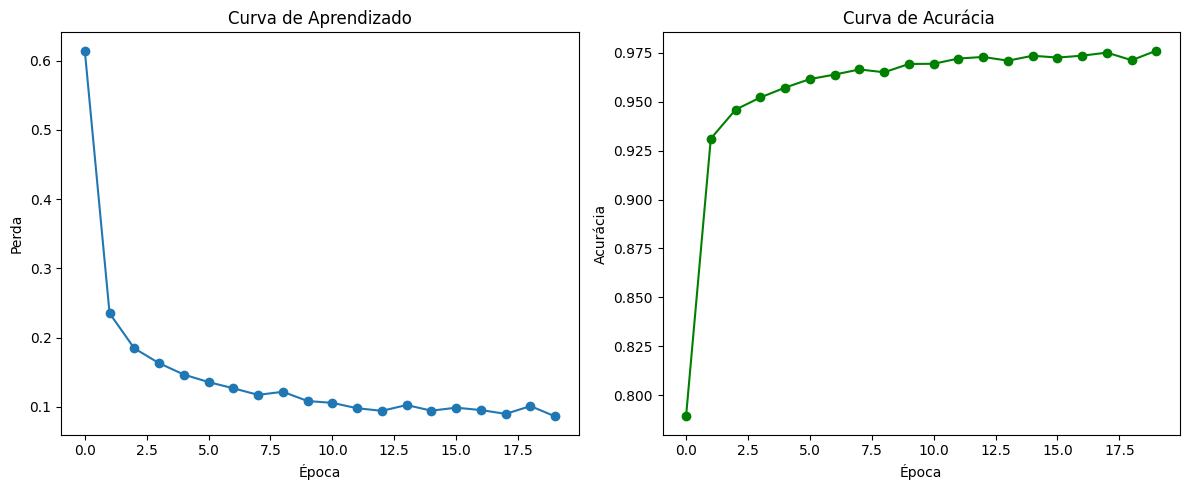

In [33]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lista_perdas, marker='o')
plt.title("Curva de Aprendizado")
plt.xlabel("Época")
plt.ylabel("Perda")

plt.subplot(1, 2, 2)
plt.plot(lista_acuracias, marker='o', color='green')
plt.title("Curva de Acurácia ")
plt.xlabel("Época")
plt.ylabel("Acurácia")

plt.tight_layout()
plt.show()

---

## **CONCLUSÃO**

A partir do desempenho dos modelos em ambas as abordagens, foi possível analisar que o modelo a partir da RNN possui um aprendizado claro e efetivo, de modo a, no segundo caso, evidenciar um aumento notório na acurácia do modelo com o aumento das épocas. Portanto, os modelos foram implementados com sucesso em ambas as abordagens.

---

## **REFERÊNCIAS**

**[1]** CASSAR, Daniel. Redes Neurais e Algoritmos Genéticos. 2025. Material de Aula.

**[2]** MISHRA, Abhinav. Building a Recurrent Neural Network (RNN) with PyTorch. Medium. 2020. Disponível em: https://medium.com/@abhinav.mishra123/building-a-recurrent-neural-network-rnn-with-pytorch-9358a696d7dc.

**[3]** DATAI. Recurrent Neural Network with PyTorch. Kaggle. Disponível em: https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch.

**[4]** PYTORCH. Classifying Names with a Character-Level RNN. PyTorch Tutorials. Disponível em: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html.

**[5]** ROBIKSCUBE. Hourly Energy Consumption. Kaggle. Disponível em: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?resource=download.

**[6]** KINGMA, Diederik P.; BA, Jimmy L.. Adam: A Method for Stochastic Optimization. arXiv. 2014. Disponível em: https://arxiv.org/pdf/1412.6980.

**[7]** TENSORFLOW. TensorFlow Keras Optimizers: Adam. Disponível em: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam.